In [ ]:
%pip install pycocotools

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision


# get device to train on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the network architecture based on ResNet18 as backbone


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.resnet = torchvision.models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(512, 2)

    def forward(self, x):
        return self.resnet(x)

def get_labels(labels, device=None):
    targets = []
    bbox = labels[0]['bbox']
    category_id = labels[0]['category_id']
    print(len(bbox))
    for i in range(len(bbox[0])):
        target = {}
        xmin, ymin, width, height = [bbox[0][i], bbox[1][i], bbox[2][i], bbox[3][i]]
        xmax = xmin + width
        ymax = ymin + height
        target['boxes'] = torch.stack([torch.tensor([xmin, ymin, xmax, ymax], dtype=torch.float32).to(device)])
        target['labels'] = torch.stack([torch.tensor(category_id[i], dtype=torch.int64).to(device)])
        targets.append(target)
    return targets

# define the loss function
criterion = nn.CrossEntropyLoss()

# define the optimizer
net = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
net = net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# load the data
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((640, 640)),
    torchvision.transforms.ToTensor()
])

# dataset_path = './dataset/FasterRCNN/'
dataset_path = './datasets/FasterRCNN/data/'
# coco dataset
train_set = torchvision.datasets.CocoDetection(
    root=dataset_path+'train',
    annFile=dataset_path+'train/_annotations.coco.json',
    transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=16, shuffle=True, num_workers=2)
test_set = torchvision.datasets.CocoDetection(
    root=dataset_path+'valid',
    annFile=dataset_path+'valid/_annotations.coco.json',
    transform=transform)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=16, shuffle=False, num_workers=2)

# train the network
for epoch in range(1):
    print('epoch: ', epoch)
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        print(labels)
        labels = get_labels(labels, device=device)
        optimizer.zero_grad()

        loss_dict = net(inputs, labels)
        loss = sum(loss for loss in loss_dict.values())

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = get_labels(labels, device=device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the test images: %d %%' % ( 100 * correct / total))


print('Finished Training')


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
epoch:  0
[{'id': tensor([49,  0,  4, 58,  3, 22, 53, 61, 45, 30, 51, 16, 23, 29, 62, 35]), 'image_id': tensor([49,  0,  4, 58,  3, 22, 53, 61, 45, 30, 51, 16, 23, 29, 62, 35]), 'category_id': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'bbox': [tensor([269, 316, 310, 292, 311, 257, 268, 289, 249, 247, 297, 294, 316, 296,
        247, 289]), tensor([321, 340, 352, 282, 305, 285, 330, 286, 307, 289, 284, 308, 329, 356,
        352, 281]), tensor([117.5000,  96.0000, 101.5000, 104.0000,  96.5000, 104.0000, 117.5000,
        104.0000,  97.5000, 104.5000, 102.0000, 102.0000,  95.5000, 107.5000,
        115.5000, 102.5000], dtype=torch.float64), tensor([83.0000, 86.5000, 82.0000, 85.5000, 98.5000, 74.5000, 70.0000, 82.0000,
        77.0000, 79.5000, 84.0000, 79.5000, 86.5000, 86.5000, 83.0000, 87.5000])], 'area': 

C:\Users\nnvuf\AppData\Local\Temp\ipykernel_8588\791779292.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target['labels'] = torch.stack([torch.tensor(category_id[i], dtype=torch.int64).to(device)])


[{'id': tensor([ 9,  1, 20, 14, 17, 12, 41, 15, 44, 36, 38, 13, 31, 47, 24, 50]), 'image_id': tensor([ 9,  1, 20, 14, 17, 12, 41, 15, 44, 36, 38, 13, 31, 47, 24, 50]), 'category_id': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'bbox': [tensor([248, 300, 249, 289, 285, 246, 297, 290, 316, 307, 266, 295, 267, 247,
        300, 288]), tensor([360, 285, 317, 358, 286, 337, 284, 281, 344, 352, 329, 290, 364, 343,
        356, 284]), tensor([120.0000, 100.0000, 100.5000, 112.5000, 103.5000, 110.0000, 102.0000,
        105.5000,  96.0000, 102.5000, 116.0000,  99.5000, 126.0000, 109.5000,
        106.5000, 103.5000]), tensor([80.5000, 89.0000, 77.0000, 83.0000, 83.0000, 79.5000, 84.0000, 90.0000,
        89.0000, 85.5000, 72.5000, 84.0000, 82.0000, 76.0000, 82.0000, 80.5000],
       dtype=torch.float64)], 'area': tensor([ 9660.0000,  8900.0000,  7738.5000,  9337.5000,  8590.5000,  8745.0000,
         8568.0000,  9495.0000,  8544.0000,  8763.7500,  8410.0000,  8358.0000,
        1

TypeError: max() received an invalid combination of arguments - got (list, int), but expected one of:
 * (Tensor input, *, Tensor out = None)
 * (Tensor input, Tensor other, *, Tensor out = None)
 * (Tensor input, int dim, bool keepdim = False, *, tuple of Tensors out = None)
 * (Tensor input, name dim, bool keepdim = False, *, tuple of Tensors out = None)


In [ ]:
# print the model's state_dict
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())
# save the model
torch.save(net.state_dict(), './model.pth')

In [91]:
log_file_path = 'logs/faster_rcnn/faster-rcnn_5-folds.log'

with open(log_file_path, 'r') as file:
    log_data = file.readlines()

# transform log_data into objects using csv.DictReader
import csv
from io import StringIO
import pandas as pd

# convert the log data into a pandas DataFrame from the csv.DictReader object
log_data = csv.DictReader(StringIO(''.join(log_data)))
log_data = pd.DataFrame(log_data)

# print the first 5 rows of the DataFrame
print(log_data.head())

  Fold Epoch          Train Loss      Test IoU Score             Accuracy
0    0     0  37.622563019394875  0.4042244489154808  0.39271409179061584
1    0     1   8.756221432238817  0.7655253949016952   0.5298259363690313
2    0     2   5.018274903297424  0.8067956405207604   0.6660248346342023
3    0     3  3.8888009898364544  19.681218789197736   0.7991144798637834
4    0     4  3.2261377219110727  1.0903358079931316   0.8534787230882324


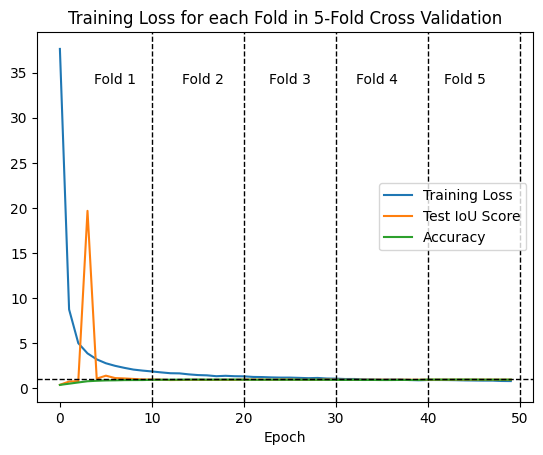

In [108]:
# display chart of the training loss
import matplotlib.pyplot as plt
import numpy as np

# plot the training loss for each fold in the same plot for comparison
train_loss = [float(loss) for loss in log_data['Train Loss']]
iou_score = [float(loss) for loss in log_data['Test IoU Score']]
accuracy = [float(loss) for loss in log_data['Accuracy']]
# convert the string values to float
plt.plot(range(log_data.__len__()), train_loss, label='Training Loss')
plt.plot(range(log_data.__len__()), iou_score, label='Test IoU Score')
plt.plot(range(log_data.__len__()), accuracy, label='Accuracy')

for i in range(5):
    # draw the line x=(i+1)*10
    plt.axvline((i+1)*10, color='black', lw=1, ls='--')
    # draw the text 'Fold i' between x=(i*10+1) and x=(i+1)*10 on top of the area
    plt.text((i*10+1)+(10-i)/2, 35, f'Fold {i+1}', horizontalalignment='center', verticalalignment='top')

# draw the line y=0
plt.axhline(1, color='black', lw=1, ls='--')

plt.xlabel('Epoch')

plt.title('Training Loss for each Fold in 5-Fold Cross Validation')
plt.legend()
plt.show()

In [87]:
log_file_path = 'logs/faster_rcnn/faster-rcnn_80-20.log'

with open(log_file_path, 'r') as file:
    log_data = file.readlines()

# transform log_data into objects using csv.DictReader
import csv
from io import StringIO
import pandas as pd

# convert the log data into a pandas DataFrame from the csv.DictReader object
log_data = csv.DictReader(StringIO(''.join(log_data)))
log_data = pd.DataFrame(log_data)

# print the first 5 rows of the DataFrame
print(log_data.head())


  Fold Epoch           Train Loss       Test IoU Score             Accuracy
0    0     0   40.786262944340706   0.3579890634913288   0.3260508716872816
1    0     1    7.203409548848867   0.8227742265999868   0.6217537544640984
2    0     2   4.2894886918365955   3.8254919168560706   0.7776887488269478
3    0     3   3.4219109676778316   1.3496286165411624   0.8648546394056892
4    0     4   3.1084013395011425    1.248259320007316   0.8700843917719763


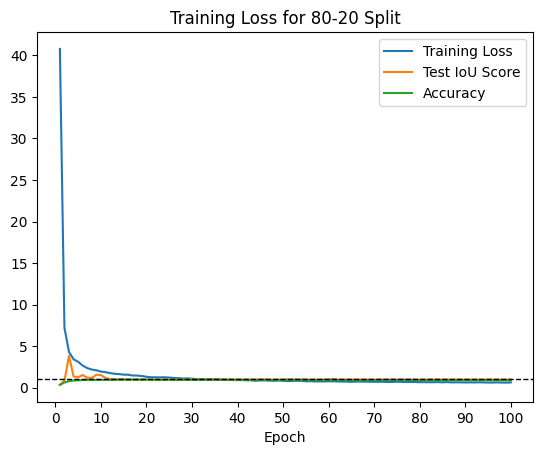

In [88]:
# display chart of the training loss
import matplotlib.pyplot as plt
import numpy as np

# plot the training loss for each fold in the same plot for comparison
train_loss = [float(loss) for loss in log_data['Train Loss']]
iou_score = [float(loss) for loss in log_data['Test IoU Score']]
accuracy = [float(loss) for loss in log_data['Accuracy']]
# convert the string values to float
plt.plot(log_data['Epoch'].map(lambda x: int(x) + 1), train_loss, label='Training Loss')
plt.plot(log_data['Epoch'].map(lambda x: int(x) + 1), iou_score, label='Test IoU Score')
plt.plot(log_data['Epoch'].map(lambda x: int(x) + 1), accuracy, label='Accuracy')

# draw the line y=0
plt.axhline(1, color='black', lw=1, ls='--')

plt.xlabel('Epoch')
plt.xticks(np.arange(0, 101, 10))
plt.title('Training Loss for 80-20 Split')
plt.legend()
plt.show()
